In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable
import copy

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get data

UKCP data

In [5]:
## get slice of UKCP mask that fits with data used:
UKCP_example_grid = xr.open_dataset('/badc/ukcp18/data/land-gcm/global/60km/rcp85/01/tasmax/day/latest/tasmax_rcp85_land-gcm_global_60km_01_day_18991201-19091130.nc').squeeze().sel(latitude=slice(50,61),longitude=slice(-12,2))
UKCP_GBR_lsm_slice = UKCP_GBR_lsm.sel(latitude=slice(50,61),longitude=slice(-12,2)).assign_coords(latitude=UKCP_example_grid.latitude,longitude=UKCP_example_grid.longitude)

In [6]:
def preproc_UKCP(ds):
    ds = ds.squeeze().sel(latitude=slice(50,61),longitude=slice(-12,2)).expand_dims('ensemble_member_id')
    ds = ds.sel(time = ds['time.month'].isin([12,1,2]))
    ds  = ds.tasmax.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    return ds

UKCP_tx = []

for y in np.arange(1,16):
    print('getting member '+"{:02d}".format(y))
    UKCP_tx += [xr.concat([preproc_UKCP(xr.open_dataset(x)) for x in glob.glob('/badc/ukcp18/data/land-gcm/global/60km/rcp85/'+"{:02d}".format(y)+'/tasmax/day/latest/*.nc')],'time')]

UKCP_tx = xr.concat(UKCP_tx,dim='ensemble_member_id')

getting member 01
getting member 02
getting member 03
getting member 04
getting member 05
getting member 06
getting member 07
getting member 08
getting member 09
getting member 10
getting member 11
getting member 12
getting member 13
getting member 14
getting member 15


In [7]:
UKCP_txm = UKCP_tx.resample(time='QS-DEC').mean()
UKCP_txm = UKCP_txm.sel(time=UKCP_txm['time.month']==12)

UKCP_txm_df = UKCP_txm.to_pandas().T

# set columns equal to 4-digit member code
UKCP_txm_df.columns = [x.decode()[-4:] for x in UKCP_txm_df.columns]
# set index equal to years (ie. the JF year)
UKCP_txm_df.index = np.arange(1900,2100)

get max tasmax too

In [8]:
UKCP_txx = UKCP_tx.resample(time='QS-DEC').max()
UKCP_txx = UKCP_txx.sel(time=UKCP_txx['time.month']==12)

UKCP_txx_df = UKCP_txx.to_pandas().T

# set columns equal to 4-digit member code
UKCP_txx_df.columns = [x.decode()[-4:] for x in UKCP_txx_df.columns]
# set index equal to years (ie. the JF year)
UKCP_txx_df.index = np.arange(1900,2100)

old retrievals:

ExSamples data

In [9]:
ExS_GBR_lsm_slice = ExS_GBR_lsm.sel(latitude=slice(62,48),longitude=slice(-13,5))

In [10]:
def preproc_ExS_tasmax(ds):
    # squeeze out unwanted dimensions
    ds = ds.squeeze()
    # rename default output names to conventional ones
    ds = ds.rename({'latitude4':'latitude','longitude4':'longitude','time1':'time','item3236_daily_maximum':'tasmax'})
    # select DJF only
    ds = ds.sel(time=ds['time.month'].isin([12,1,2]))
    # ensure spatial coords match the lsm exactly
    ds = ds.assign_coords(latitude=ExS_GBR_lsm_slice.latitude,longitude=ExS_GBR_lsm_slice.longitude)
    return ds

def preproc_ExS_maxtasmax(ds):
    ds = preproc_ExS_tasmax(ds).tasmax
    # average over UK land
    ds = ds.where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    # take time maximum
    ds = ds.max('time')
    return ds

def preproc_ExS_meantasmax(ds):
    ds = preproc_ExS_tasmax(ds).tasmax
    # take time mean at each gridpoint
    ds = ds.mean('time')
    # average over UK land
    ds = ds.where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_GBR_lsm_slice.latitude))).mean(['latitude','longitude'])
    return ds

def get_mean_max_tasmax(path):
    ds = xr.open_dataset(path)
    return [preproc_ExS_meantasmax(ds).to_pandas(),preproc_ExS_maxtasmax(ds).to_pandas()]
    
ExS_1554_fut = pd.concat(get_mean_max_tasmax(ExS_dataloc+'HotWinter2072-r001i1p01554/UK/tasmax_daily/HotWinter2072-r001i1p01554_tasmax_daily_UK_members0000-0882.nc'),axis=1,keys=['txm','txx'])
ExS_2242_fut = pd.concat(get_mean_max_tasmax(ExS_dataloc+'WetWinter2068-r001i1p02242/UK/tasmax_daily/WetWinter2068-r001i1p02242_tasmax_daily_UK_members0000-0916.nc'),axis=1,keys=['txm','txx'])
ExS_2868_fut = pd.concat(get_mean_max_tasmax(ExS_dataloc+'HotWinter2066-r001i1p02868/UK/tasmax_daily/HotWinter2066-r001i1p02868_tasmax_daily_UK_members0000-1035.nc'),axis=1,keys=['txm','txx'])

ExS_1554_base = pd.concat([pd.concat(get_mean_max_tasmax(x),axis=1,keys=['txm','txx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/tasmax_daily/*1554*.nc')],axis=0)
ExS_2242_base = pd.concat([pd.concat(get_mean_max_tasmax(x),axis=1,keys=['txm','txx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/tasmax_daily/*2242*.nc')],axis=0)
ExS_2868_base = pd.concat([pd.concat(get_mean_max_tasmax(x),axis=1,keys=['txm','txx']) for x in glob.glob(ExS_dataloc+'BaselineWinters/UK/tasmax_daily/*2868*.nc')],axis=0)

In [11]:
## concatenate for easy functional coding
ExS_fut = pd.concat([ExS_1554_fut,ExS_2242_fut,ExS_2868_fut],keys=['1554','2242','2868'])
ExS_base = pd.concat([ExS_1554_base,ExS_2242_base,ExS_2868_base],keys=['1554','2242','2868'])

Slice out the analogs from each ensemble

In [12]:
analog_list = pd.read_csv('../output/data/manuscript-analogs.csv')['0'].values

In [13]:
ExS_fut_analogs = ExS_fut.reindex(set(analog_list).intersection(ExS_fut.index.levels[1]),level=1)
ExS_base_analogs = ExS_base.reindex(set(analog_list).intersection(ExS_base.index.levels[1]),level=1)

## Analyse and create figure

preprocess UKCP 2061-2080

In [14]:
txm_olse = OLSE.simple(UKCP_txm_df.loc[2061:2080])
txm_olse.fit(np.arange(20)[:,None])

UKCP_txm_detrend_df = (pd.DataFrame().reindex_like(UKCP_txm_df.loc[2061:2080]).fillna(0) + txm_olse.res.data)
UKCP_txm_detrend_df -= UKCP_txm_detrend_df.mean()

txx_olse = OLSE.simple(UKCP_txx_df.loc[2061:2080])
txx_olse.fit(np.arange(20)[:,None])

UKCP_txx_detrend_df = (pd.DataFrame().reindex_like(UKCP_txx_df.loc[2061:2080]).fillna(0) + txx_olse.res.data)
UKCP_txx_detrend_df -= UKCP_txx_detrend_df.mean()

In [15]:
## concat for easy functional programming
UKCP_detrend_df = pd.concat([UKCP_txm_detrend_df,UKCP_txx_detrend_df],axis=1,keys=['txm','txx'])
UKCP_df = pd.concat([UKCP_txm_df,UKCP_txx_df],axis=1,keys=['txm','txx'])

In [16]:
## preproecssing definition:

def preproc_data_for_fig(select_winter,var='txm',analogs=False):
    
    # get info about chosen winter
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    # set the UKCP 2061-80 deviations population relative to the difference between the UKCP baseline average temp and the UKCP 10-year window average centered on the chosen winter
    UKCP_fut_pop = UKCP_detrend_df[var].values.flatten() - UKCP_df[var].loc[2007:2016].values.mean() + UKCP_df[var].loc[int(year)-5:int(year)+5].values.mean()
    # set the UKCP baseline relative to its own average
    UKCP_base_pop = (UKCP_df[var].loc[2007:2016] - UKCP_df[var].loc[1997:2026].mean()).values.flatten()
    
    ExS_fut_pop = ExS_fut.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
    ExS_base_pop = ExS_base.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
    
    if analogs:
        ExS_fut_pop_analogs = ExS_fut_analogs.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
        ExS_base_pop_analogs = ExS_base_analogs.loc[run[-4:],var].values - ExS_base.loc[run[-4:],var].values.mean()
            
        return UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs

    return UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop

create distribution features shown in figure

In [17]:
### write definition for carrying out the computating automatically

def create_main_fig(select_winter,var='txm',statmodel=LMoments.gpd):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,analogs=True)
    
    # use first definition for ANOMALIES, second for deviations
#     UKCP_selected_winter = UKCP_df.loc[int(year),(var,run[-4:])] - UKCP_df.loc[1997:2026,(var,run[-4:])].mean()
    UKCP_selected_winter = UKCP_detrend_df.loc[int(year),(var,run[-4:])] - UKCP_df[var].loc[2007:2016].values.mean() + UKCP_df[var].loc[int(year)-5:int(year)+5].values.mean()
    
    if statmodel == LMoments.gpd:
        
        gpd_threshold = 0.75
        
    else:
        
        gpd_threshold = 0
        
    UKCP_statmodel = statmodel()
    UKCP_statmodel.fit(UKCP_fut_pop[UKCP_fut_pop>=np.quantile(UKCP_fut_pop,gpd_threshold)])

    ## calculate ExSamples statistical CDF
    ExS_CDF = np.where( ExS_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(ExS_fut_pop)*(1-gpd_threshold) , (ExS_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    ExS_RP = 1/(1-ExS_CDF)

    ## calculate UKCP statistical CDF
    UKCP_CDF = np.where( UKCP_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(UKCP_fut_pop)*(1-gpd_threshold) , (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    UKCP_RP = 1/(1-UKCP_CDF)

    UKCP_ECDF = (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size
    UKCP_ERP = 1/(1-UKCP_ECDF)
    
    ## bootstrap the statistical model for 5-95 curves
    n_boot=10000
    
    ## create bootstrap samples + select members above quantile selected
    UKCP_fut_pop_boot = UKCP_fut_pop[np.random.choice(UKCP_fut_pop.size,UKCP_fut_pop.size*n_boot)].reshape(UKCP_fut_pop.size,-1)
    UKCP_fut_pop_boot = np.take_along_axis(UKCP_fut_pop_boot,UKCP_fut_pop_boot.argsort(axis=0),axis=0)[-int(np.ceil(UKCP_fut_pop_boot.shape[0]*(1-gpd_threshold))):]

    ## initialise a new distribution object
    UKCP_statmodel_boot = statmodel()
    ## and fit to each resample
    UKCP_statmodel_boot.fit(UKCP_fut_pop_boot)
    
    # create xrange for statmodel curve
    UKCP_statmodel_xrange = np.arange(np.quantile(UKCP_fut_pop,gpd_threshold),np.ceil(ExS_fut_pop.max()*1.2),0.01)
    UKCP_statmodel_CDF = UKCP_statmodel_boot.cdf(UKCP_statmodel_xrange[:,None])
    
    ## create colors:

    base_color = winter_colors.loc[run[-4:]]
    dark_color = matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(base_color),1.5)))

    base_grey = 'xkcd:grey'
    dark_grey = 'xkcd:dark grey'
    
    ## create figure
    
    fig = plt.figure(figsize=(9,9))
    gs = fig.add_gridspec(2,2,hspace=0.3,wspace=0.3)
    dist_gs = gs[0,:].subgridspec(12,1,hspace=0,wspace=0)

    sample_ax = fig.add_subplot(gs[1,1],zorder=2)
    dist_ax = fig.add_subplot(dist_gs[:,0],zorder=2)
    ana_dist_ax = fig.add_subplot(dist_gs[0,0],zorder=3)
    rp_ax = fig.add_subplot(gs[1,0],zorder=1)

    ## plot distributions
    ### future distributions
    sn.kdeplot(x=UKCP_fut_pop,ax=dist_ax,color=base_color,lw=2,label='UKCP 2061-2080 ('+str((UKCP_fut_pop>UKCP_selected_winter).sum())+'/'+str(UKCP_fut_pop.size)+')')
    sn.kdeplot(x=ExS_fut_pop,ax=dist_ax,color=dark_color,lw=2,label=label+' ensemble ('+str((ExS_fut_pop>UKCP_selected_winter).sum())+'/'+str(ExS_fut_pop.size)+')')

    ### baseline distributions
    sn.kdeplot(x=UKCP_base_pop,ax=dist_ax,color=base_grey,lw=2,label='UKCP 2007-2016 ('+str((UKCP_base_pop>UKCP_selected_winter).sum())+'/'+str(UKCP_base_pop.size)+')')
    sn.kdeplot(x=ExS_base_pop,ax=dist_ax,color=dark_grey,lw=2,label=label+'-B ensemble ('+str((ExS_base_pop>UKCP_selected_winter).sum())+'/'+str(ExS_base_pop.size)+')')
    
    ### analog distributions for txm
    if var=='txm':
        
        ana_dist_ax.plot(np.quantile(ExS_fut_pop_analogs,[0.16,0.84]),[1,1],color=dark_color,lw=2,clip_on=False)
        ana_dist_ax.plot(np.mean(ExS_fut_pop_analogs),1,color=dark_color,marker='o',lw=2,clip_on=False)
        ana_dist_ax.plot(np.quantile(ExS_base_pop_analogs,[0.16,0.84]),[0,0],color=dark_grey,lw=2,clip_on=False)
        ana_dist_ax.plot(np.mean(ExS_base_pop_analogs),0,color=dark_grey,marker='o',lw=2,clip_on=False)
        
        ## set xlimits to more aesthetic limits
        ana_dist_ax.set_ylim(-2.5,1.5)
        
        ## add threshold value
#         ana_dist_ax.axvline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5)
        
        dist_ax.plot([],[],color=dark_color,marker='o',lw=2,label=label+' ensemble analogs ('+str((ExS_fut_pop_analogs>UKCP_selected_winter).sum())+'/'+str(ExS_fut_pop_analogs.size)+')')
        dist_ax.plot([],[],color=dark_grey,marker='o',lw=2,label=label+'-B ensemble analogs ('+str((ExS_base_pop_analogs>UKCP_selected_winter).sum())+'/'+str(ExS_base_pop_analogs.size)+')')

    ### threshold value
    dist_ax.axvline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5, label=label+' winter')

    ## plot return period diagram
    ### empirical sample
    rp_ax.semilogx(UKCP_ERP,UKCP_fut_pop,'.',c=base_color,label='UKCP 2061-2080')

    ### statistical model curve
    rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
    ### for the CIs, only plot the upper quintile
    xrange_idx_ci = np.argmin(np.abs(UKCP_statmodel_xrange-np.quantile(UKCP_fut_pop,0.75)))
    rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.05,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 5-95%')
    rp_ax.semilogx((1/(1-np.where(np.quantile(UKCP_statmodel_CDF,0.95,axis=1)==1,1-1e-15,np.quantile(UKCP_statmodel_CDF,0.95,axis=1)))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:')

    ### threshold value
    rp_ax.axhline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5,label=label+' winter')
    # rp_ax.hlines(UKCP_selected_winter, 1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold), 1e6, ls='--', color=base_color, lw=2)

    ### ExSamples rugplot
    sn.rugplot(y=ExS_fut_pop,height=0.05,lw=0.2,color=dark_color,label=label+' ensemble',zorder=-2)

    ### hline for threshold RP
    # rp_ax.vlines(1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold), UKCP_selected_winter, 10, ls='--', color=base_color, lw=2)
    rp_ax.axvline(1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold), ls='--', color=base_color, lw=1.5)

    ## plot sampling plot

    ### Generate background lines
    ### RPs
    x = 10**np.arange(0,6.1,0.1)
    ### ensemble sizes
    z = 10**np.arange(1,6.1,0.1)
    x,z = np.meshgrid(x,z)

    ## choose proportionality between bins & RPs:
    b_RP_const = 0.5

    ## create bins array
    bins = (1+b_RP_const)**np.arange(np.ceil(np.log(1e6)/np.log(1+b_RP_const)))

    # compute y values for contour plot
    y = b_RP_const*z/(x*(b_RP_const+1))

    sample_ax.hist(UKCP_RP,bins=bins,cumulative=False,density=False,lw=2,histtype='step',color=base_color,label='UKCP 2061-2080')
    sample_ax.hist(ExS_RP,bins=bins,density=False,lw=2,histtype='step',color=dark_color,label=label+' ensemble')
    sample_ax.axvline(1/(1-np.median(UKCP_statmodel_boot.cdf(UKCP_selected_winter)))/(1-gpd_threshold),color=base_color,ls='--',lw=1.5,label=label+' winter')

    sample_ax.set_xscale('log')
    sample_ax.set_yscale('log')

    sample_xlim = min(1e6,10**np.ceil(np.log10(ExS_RP.max())))

    clevels = np.array([int(10**x) for x in np.arange(1,7)]+[int(3*10**x) for x in np.arange(1,6)])
    clevels = clevels[clevels<=sample_xlim]
    clevels = clevels[np.argsort(clevels)]

    c=sample_ax.contour(x,y,z,levels=clevels,colors='k',alpha=0.5)
    
    clabel_xlocs = (10**(1/2)*clevels/3)**(np.log10(sample_xlim)/(3.5+np.log10(sample_xlim)))
    clabel_ylocs = clevels/(3*clabel_xlocs)
    clabels = sample_ax.clabel(c,fmt=r'%4d',manual=[[x,clabel_ylocs[i]] for i,x in enumerate(clabel_xlocs)])
    [l.set_rotation(-np.rad2deg(np.arctan(np.log(sample_xlim)/np.log(10**(3.5))))) for l in clabels]
    [l.set_alpha(0.5) for l in clabels]

    ## adjust layout
    dist_ylim = [np.floor(min(UKCP_base_pop.min(),ExS_base_pop.min()))-1,np.ceil(max(UKCP_fut_pop.max(),ExS_fut_pop.max()))+1+1e-9]
    [a.set_xlim(*dist_ylim) for a in [dist_ax,ana_dist_ax]]
    [a.set_xticks(np.arange(*dist_ylim)) for a in [dist_ax,ana_dist_ax]]
    
    [a.set_xlim(1,sample_xlim) for a in [sample_ax,rp_ax]]
    
    rp_ylim = [np.floor(min(UKCP_fut_pop.min(),ExS_fut_pop.min()))-1,np.ceil(max(UKCP_fut_pop.max(),ExS_fut_pop.max()))+1+1e-9]
    rp_ax.set_ylim(*rp_ylim)
    rp_ax.set_yticks(np.arange(*rp_ylim))

#     sample_ax.set_xticklabels([])
#     [a.set_xticklabels([]) for a in [dist_ax,ana_dist_ax]]
#     [a.set_yticks([]) for a in [dist_ax,ana_dist_ax]]
    [a.set_ylabel('') for a in [dist_ax,ana_dist_ax]]
    dist_ax.set_ylabel('density')
    ana_dist_ax.set_xticks([])
    ana_dist_ax.set_yticks([])
    
    ## make background transparent
    ana_dist_ax.patch.set_alpha(0)

    sample_ax.set_ylim(0.1**(1/2),1e3)

    vartype = 'mean' if var=='txm' else 'max'
    [x('UK DJF '+vartype+' tasmax anomaly / \N{DEGREE SIGN}C') for x in [rp_ax.set_ylabel,dist_ax.set_xlabel]]
    [x('return period / yrs') for x in [rp_ax.set_xlabel,sample_ax.set_xlabel]]

    sample_ax.set_ylabel('ensemble member count')

    sn.despine()
    sn.despine(ax=ana_dist_ax,left=True,bottom=True)

    dist_ax.legend(loc=1 if var=='txx' else 2,frameon=False,fontsize='small')
    rp_ax.legend(frameon=False,loc=4,fontsize='small')
    sample_ax.legend(frameon=False,loc=1,fontsize='small')
    
    [a.text(0,1.02,['A','B','C'][i],transform=a.transAxes,va='bottom',ha='left',fontweight='bold',fontsize='large') for i,a in enumerate([dist_ax,rp_ax,sample_ax])]

    return fig

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


''

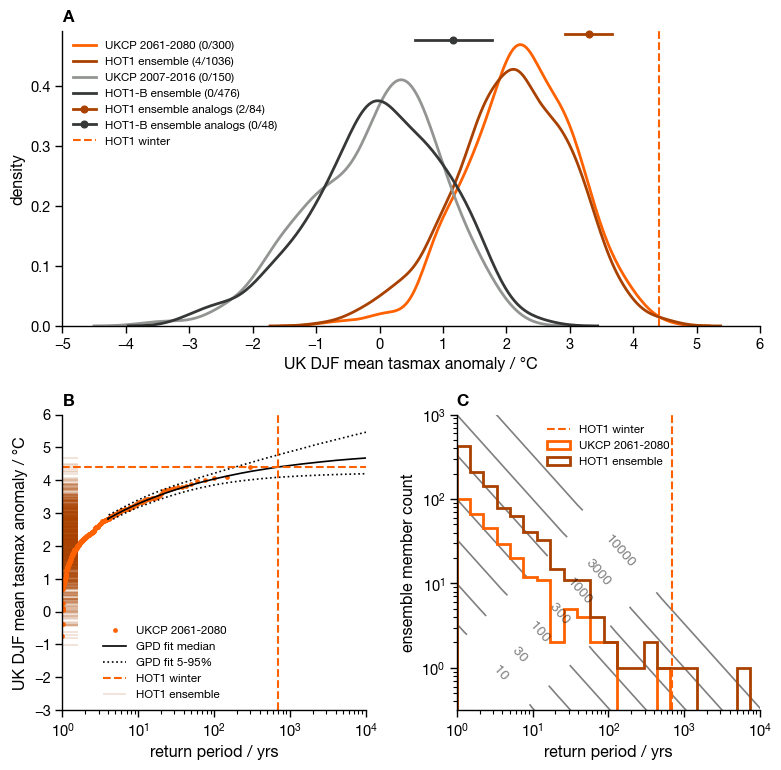

In [60]:
fig=create_main_fig('fut_2066','txm',statmodel=LMoments.gpd)

# histogram legend
fig.axes[0].legend(frameon=False,loc=9,fontsize='small')
# rp legend
fig.axes[3].legend(frameon=False,loc='lower left',bbox_to_anchor=(0.1,0.0),fontsize='small')

fig.dpi=100

[fig.savefig('../output/figs/FIG3.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
<ipython-input-17-d8b1527be5cd>:28: RuntimeWarning: divide by zero encountered in true_divide
  ExS_RP = 1/(1-ExS_CDF)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
<ipython-input-17-d8b1527be5cd>:109: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.05,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 5-95%')
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*

''

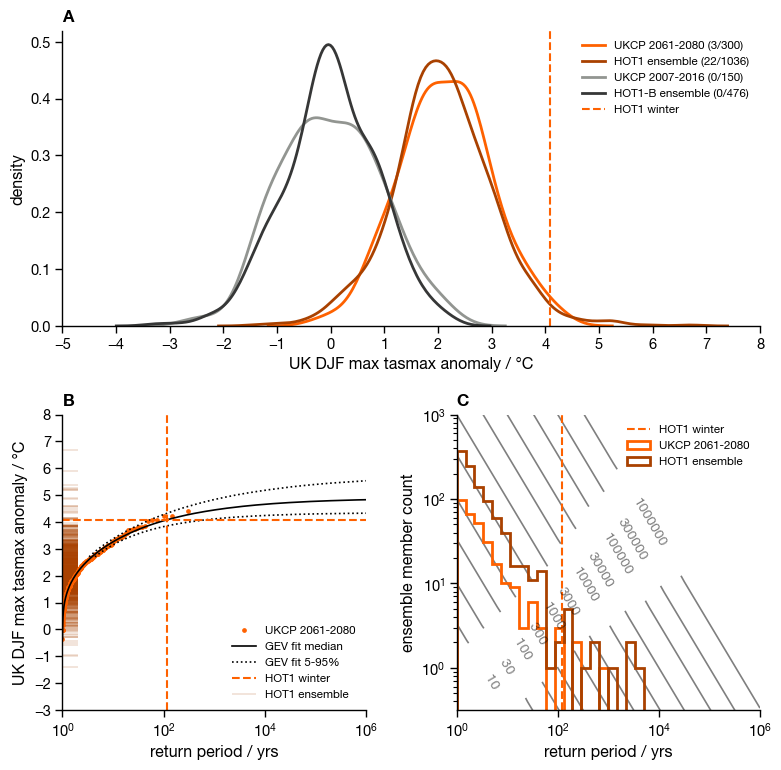

In [19]:
fig=create_main_fig('fut_2066','txx',statmodel=LMoments.gev)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS7.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


''

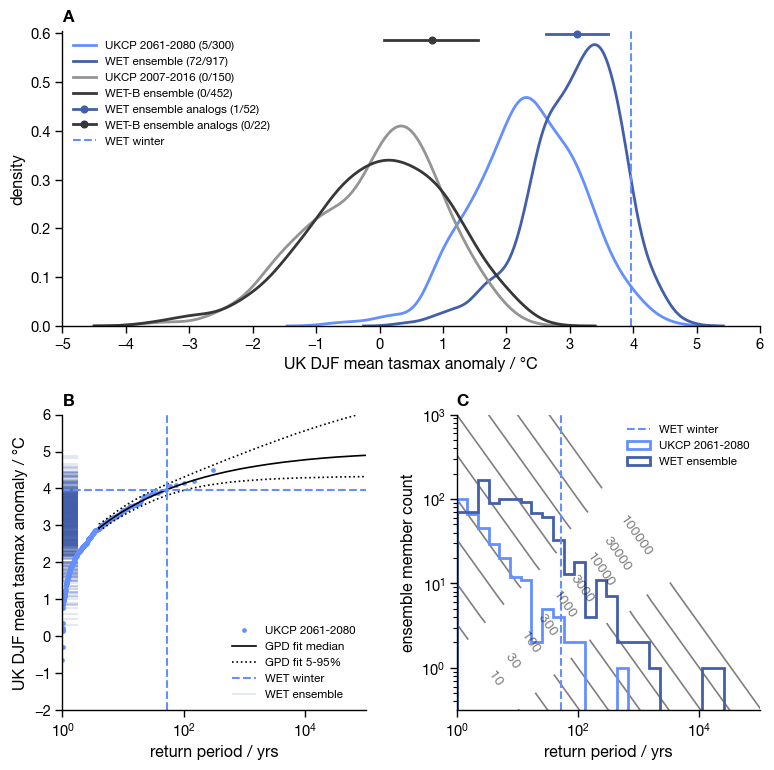

In [20]:
fig=create_main_fig('fut_2068','txm',statmodel=LMoments.gpd)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS4.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
<ipython-input-17-d8b1527be5cd>:28: RuntimeWarning: divide by zero encountered in true_divide
  ExS_RP = 1/(1-ExS_CDF)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
<ipython-input-17-d8b1527be5cd>:109: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.05,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 5-95%')


''

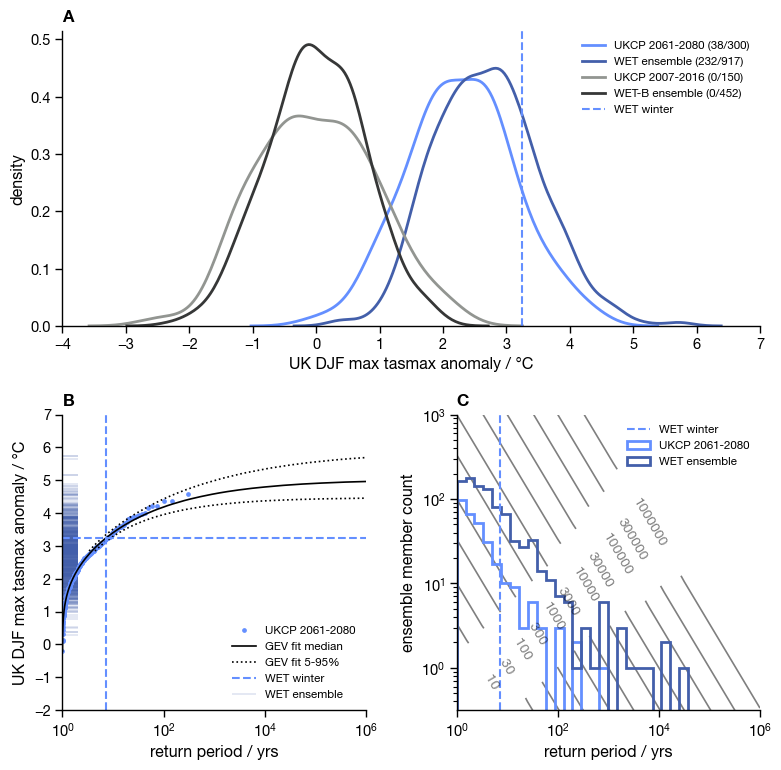

In [21]:
fig=create_main_fig('fut_2068','txx',statmodel=LMoments.gev)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS9.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

<ipython-input-17-d8b1527be5cd>:28: RuntimeWarning: divide by zero encountered in true_divide
  ExS_RP = 1/(1-ExS_CDF)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)
/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:438: RuntimeWarning: invalid value encountered in power
  cdf = 1 - ( 1 - self.k*(x-self.X)/self.a )**(1/self.k)


''

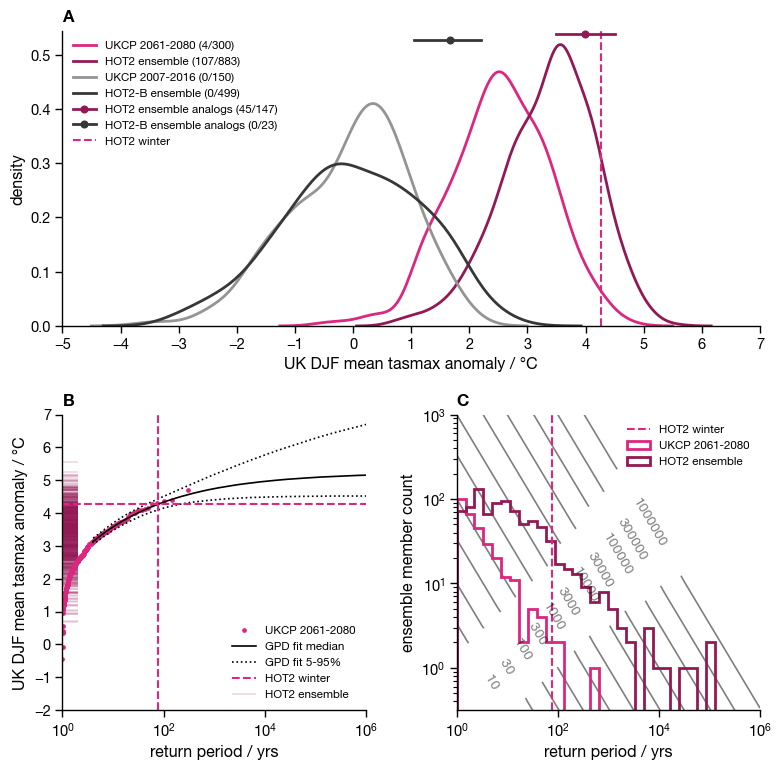

In [61]:
fig=create_main_fig('fut_2072','txm',statmodel=LMoments.gpd)

fig.dpi=100

[fig.savefig('../output/figs/FIG4.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
<ipython-input-17-d8b1527be5cd>:28: RuntimeWarning: divide by zero encountered in true_divide
  ExS_RP = 1/(1-ExS_CDF)
<ipython-input-17-d8b1527be5cd>:106: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
<ipython-input-17-d8b1527be5cd>:109: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.05,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 5-95%')


''

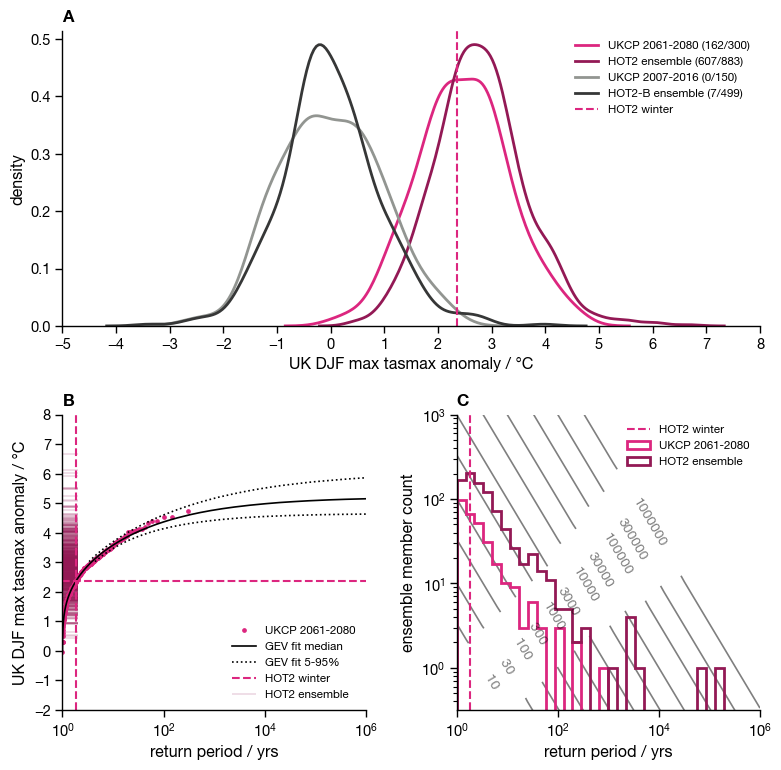

In [23]:
fig=create_main_fig('fut_2072','txx',statmodel=LMoments.gev)

fig.dpi=100

[fig.savefig('../output/figs/SI/FIGS8.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

### Return period diagram for TXx 02868:

In [24]:
### write definition for carrying out the computating automatically

def create_rp_fig(select_winter='fut_2066',var='txx',statmodel=LMoments.gev):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,analogs=True)
    
    UKCP_selected_winter = UKCP_df.loc[int(year),(var,run[-4:])] - UKCP_df.loc[1997:2026,(var,run[-4:])].mean()
    
    if statmodel == LMoments.gpd:
        
        gpd_threshold = 0.75
        
    else:
        
        gpd_threshold = 0
        
    UKCP_statmodel = statmodel()
    UKCP_statmodel.fit(UKCP_fut_pop[UKCP_fut_pop>=np.quantile(UKCP_fut_pop,gpd_threshold)])

    ## calculate ExSamples statistical CDF
    ExS_CDF = np.where( ExS_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(ExS_fut_pop)*(1-gpd_threshold) , (ExS_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    ExS_RP = 1/(1-ExS_CDF)

    ## calculate UKCP statistical CDF
    UKCP_CDF = np.where( UKCP_fut_pop >= np.quantile(UKCP_fut_pop,gpd_threshold) , gpd_threshold + UKCP_statmodel.cdf(UKCP_fut_pop)*(1-gpd_threshold) , (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size )
    UKCP_RP = 1/(1-UKCP_CDF)

    UKCP_ECDF = (UKCP_fut_pop[None]>UKCP_fut_pop[:,None]).sum(axis=0) / UKCP_fut_pop.size
    UKCP_ERP = 1/(1-UKCP_ECDF)
    
    ## bootstrap the statistical model for 5-95 curves
    n_boot=100000
    
    ## create bootstrap samples + select members above quantile selected
    UKCP_fut_pop_boot = UKCP_fut_pop[np.random.choice(UKCP_fut_pop.size,UKCP_fut_pop.size*n_boot)].reshape(UKCP_fut_pop.size,-1)
    UKCP_fut_pop_boot = np.take_along_axis(UKCP_fut_pop_boot,UKCP_fut_pop_boot.argsort(axis=0),axis=0)[-int(np.ceil(UKCP_fut_pop_boot.shape[0]*(1-gpd_threshold))):]

    ## initialise a new distribution object
    UKCP_statmodel_boot = statmodel()
    ## and fit to each resample
    UKCP_statmodel_boot.fit(UKCP_fut_pop_boot)
    
    # create xrange for statmodel curve
    UKCP_statmodel_xrange = np.arange(np.quantile(UKCP_fut_pop,gpd_threshold),np.ceil(ExS_fut_pop.max()*1.2),0.01)
    UKCP_statmodel_CDF = UKCP_statmodel_boot.cdf(UKCP_statmodel_xrange[:,None])
    
    ## create colors:

    base_color = winter_colors.loc[run[-4:]]
    dark_color = matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(base_color),1.5)))

    base_grey = 'xkcd:grey'
    dark_grey = 'xkcd:dark grey'
    
    ## create figure
    
    fig,rp_ax = plt.subplots(figsize=(4.5,4.5))

    ## plot return period diagram
    ### empirical sample
    rp_ax.semilogx(UKCP_ERP,UKCP_fut_pop,'.',c=base_color,label='UKCP 2061-2080')

    ### statistical model curve
    rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
    ### for the CIs, only plot the upper quintile
    xrange_idx_ci = np.argmin(np.abs(UKCP_statmodel_xrange-np.quantile(UKCP_fut_pop,0.75)))
    rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.001,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 0.1-99.9%')
    rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.999,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:')

    ### ExSamples max value
    rp_ax.axhline(ExS_fut_pop.max(), ls='--', color=dark_color, lw=1.5,label=label+' member c0qu')

    ### ExSamples rugplot
    sn.rugplot(y=ExS_fut_pop,height=0.05,lw=0.2,color=dark_color,label=label+' ensemble',zorder=-2)

    sample_xlim = min(1e6,10**np.ceil(np.log10(ExS_RP.max())))
    
    ## adjust layout
    dist_ylim = [np.floor(ExS_fut_pop.min()-0.1*(ExS_fut_pop.max()-ExS_fut_pop.min())),1e-3+np.ceil(ExS_fut_pop.max()+0.1*(ExS_fut_pop.max()-ExS_fut_pop.min()))]
    [a.set_ylim(*dist_ylim) for a in [rp_ax]]
    [a.set_xlim(1,sample_xlim) for a in [rp_ax]]
    [a.set_yticks(np.arange(*dist_ylim)) for a in [rp_ax]]

    vartype = 'mean' if var=='txm' else 'max'
    rp_ax.set_ylabel('UK DJF '+vartype+' tasmax anomaly / \N{DEGREE SIGN}C')
    rp_ax.set_xlabel('return period / yrs')

    rp_ax.legend(frameon=False,loc=4,fontsize='small')

    return fig,UKCP_statmodel_boot,ExS_fut_pop

/home/users/njleach/mystatsfunctions/mystatsfunctions/LMoments.py:244: RuntimeWarning: invalid value encountered in power
  cdf = np.exp(-1*(1-self.k*((x-self.X)/self.a))**(1/self.k))
<ipython-input-24-efce58c870e7>:26: RuntimeWarning: divide by zero encountered in true_divide
  ExS_RP = 1/(1-ExS_CDF)
<ipython-input-24-efce58c870e7>:68: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx(1/(1-np.median(UKCP_statmodel_CDF,axis=1))/(1-gpd_threshold),UKCP_statmodel_xrange,'k',label=str.upper(str(statmodel)[-5:-2])+' fit median')
<ipython-input-24-efce58c870e7>:71: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF,0.001,axis=1))/(1-gpd_threshold))[xrange_idx_ci:],UKCP_statmodel_xrange[xrange_idx_ci:],'k:',label=str.upper(str(statmodel)[-5:-2])+' fit 0.1-99.9%')
<ipython-input-24-efce58c870e7>:72: RuntimeWarning: divide by zero encountered in true_divide
  rp_ax.semilogx((1/(1-np.quantile(UKCP_statmodel_CDF

''

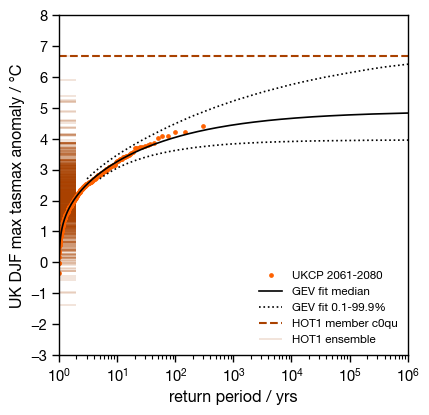

In [62]:
fig,UKCP_statmodel_boot,ExS_fut_pop=create_rp_fig()

fig.dpi=100

[fig.savefig('../output/figs/FIG6.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

In [26]:
print('Quantile of ExSamples 2066 max within UKCP18 GEV bootstrapped threshold:',sp.stats.percentileofscore(UKCP_statmodel_boot.qf(1),ExS_fut_pop.max()),'%')

Quantile of ExSamples 2066 max within UKCP18 GEV bootstrapped threshold: 99.689 %


In [27]:
np.quantile((ExS_fut_pop.max()-UKCP_statmodel_boot.data.mean(axis=0))/UKCP_statmodel_boot.data.std(axis=0),[0.05,0.5,0.95])

array([5.00095025, 5.3439201 , 5.73045207])

### Explanatory distribution plots for txm

In [28]:
def create_dist_fig(select_winter='fut_2072',var='txm'):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values

    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,analogs=True)

    UKCP_selected_winter = UKCP_df.loc[int(year),(var,run[-4:])] - UKCP_df.loc[1997:2026,(var,run[-4:])].mean()

    base_color = winter_colors.loc[run[-4:]]
    dark_color = matplotlib.colors.to_hex(tuple(np.divide(matplotlib.colors.to_rgb(base_color),1.5)))

    base_grey = 'xkcd:grey'
    dark_grey = 'xkcd:dark grey'

    ## create figure

    fig,dist_ax = plt.subplots(figsize=(4.5,4.5))

    ## plot distributions
    ### future distributions
    sn.ecdfplot(x=UKCP_fut_pop,ax=dist_ax,color=base_color,lw=2,label='UKCP18 PPE 2061-2080')
    sn.ecdfplot(x=ExS_fut_pop,ax=dist_ax,color=dark_color,lw=2,label='ExSamples '+year)

    ### analog distributions for txm
    if var=='txm':
        
        sn.ecdfplot(x=ExS_fut_pop_analogs,ax=dist_ax,ls=':',color=dark_color,lw=2,label='ExSamples '+year+' analogs')

    ### threshold value
    dist_ax.axvline(UKCP_selected_winter, ls='--', color=base_color, lw=1.5, label=label)
    
    ### arrows
    dist_ax.annotate('',xy=(np.median(ExS_fut_pop),0.5),xytext=(np.median(UKCP_fut_pop),0.5),arrowprops=dict(facecolor='black', arrowstyle='->'))
    dist_ax.text((np.median(UKCP_fut_pop)+np.median(ExS_fut_pop))/2,0.51,'BCs',ha='center',va='bottom')
    
    dist_ax.annotate('',xy=(np.median(ExS_fut_pop_analogs),0.5),xytext=(np.median(ExS_fut_pop),0.5),arrowprops=dict(facecolor='black', arrowstyle='->'))
    dist_ax.text((np.median(ExS_fut_pop)+np.median(ExS_fut_pop_analogs))/2-0.03,0.49,'dyn',ha='center',va='top')
    
    dist_ax.annotate('',xy=(UKCP_selected_winter,0.5),xytext=(np.median(ExS_fut_pop_analogs),0.5),arrowprops=dict(facecolor='black', arrowstyle='->'))
    dist_ax.text((UKCP_selected_winter+np.median(ExS_fut_pop_analogs))/2+0.03,0.51,'I.V.',ha='center',va='bottom')
    
    ## adjust layout
    dist_ylim = [UKCP_fut_pop.min(),ExS_fut_pop.max()]
    [a.set_xlim(*dist_ylim) for a in [dist_ax]]
    
    dist_ax.set_ylabel('Cumulative probability')
    
    vartype = 'mean' if var=='txm' else 'max'
    dist_ax.set_xlabel('UK DJF '+vartype+' tasmax anomaly / \N{DEGREE SIGN}C')
    
    dist_ax.legend(loc=2,frameon=False,fontsize='small')

#     sn.despine()

    return fig

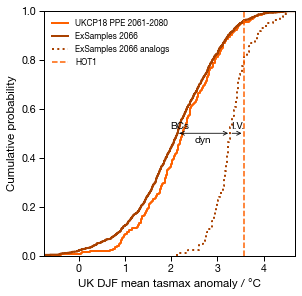

In [29]:
fig=create_dist_fig(select_winter='fut_2066',var='txm')

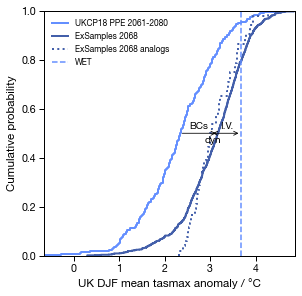

In [30]:
fig=create_dist_fig(select_winter='fut_2068',var='txm')

''

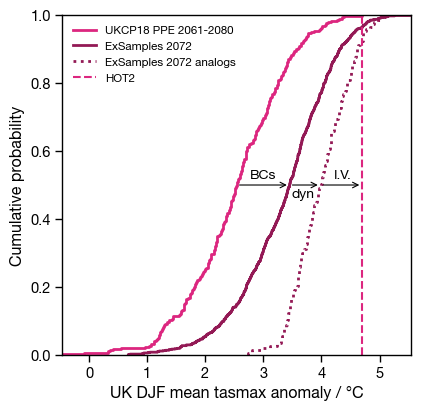

In [31]:
fig=create_dist_fig(select_winter='fut_2072',var='txm')

fig.dpi=100

# [fig.savefig('../output/figs/SI/FIGS9-01554-mean-tasmax-schematic.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

## Statistical comparison of ensembles

#### Absolute number of extremes sampled higher than the highest magnitude UKCP18 extreme

In [32]:
greater_extremes = 0

for select_winter in run_info.index:
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var='txm')
    greater_extremes += (ExS_fut_pop>UKCP_fut_pop.max()).sum()
    
print('number of txm extremes that exceed the greatest in UKCP18:',greater_extremes)

number of txm extremes that exceed the greatest in UKCP18: 44


In [33]:
greater_extremes = 0

for select_winter in run_info.index:
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var='txx')
    greater_extremes += (ExS_fut_pop>UKCP_fut_pop.max()).sum()
    
print('number of txx extremes that exceed the greatest in UKCP18:',greater_extremes)

number of txx extremes that exceed the greatest in UKCP18: 47


#### Extreme conditioning
Fraction of ExSamples over UKCP18 90/95/99th percentiles.

In [34]:
### write definition for carrying out the computating automatically

def get_extreme_fraction(select_winter,var='txm',statmodel=LMoments.gpd,quantiles=[0.9,0.95,0.99]):
    
    ## select_winter is one of [fut_2066, fut_2068, fut_2072]
    
    ensmem,year,run,extreme,label = run_info.loc[select_winter].values
    
    UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var=var,analogs=True)
    
    if statmodel == LMoments.gpd:
        
        gpd_threshold = 0.75
        
    else:
        
        gpd_threshold = 0
    
    ## bootstrap the statistical model for 5-95 curves
    n_boot=10000
    
    ## create bootstrap samples + select members above quantile selected
    UKCP_fut_pop_boot = UKCP_fut_pop[np.random.choice(UKCP_fut_pop.size,UKCP_fut_pop.size*n_boot)].reshape(UKCP_fut_pop.size,-1)
    UKCP_fut_pop_boot = np.take_along_axis(UKCP_fut_pop_boot,UKCP_fut_pop_boot.argsort(axis=0),axis=0)[-int(np.ceil(UKCP_fut_pop_boot.shape[0]*(1-gpd_threshold))):]

    ## initialise a new distribution object
    UKCP_statmodel_boot = statmodel()
    ## and fit to each resample
    UKCP_statmodel_boot.fit(UKCP_fut_pop_boot)
    
    UKCP_extreme_threshold = np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])
    
    results = pd.DataFrame(columns=pd.MultiIndex.from_product([quantiles,[0.05,0.5,0.95]],names=['extreme quantile','unc quantile']))
    
    results.loc['ExS fut'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/ExS_fut_pop.size
    results.loc['ExS fut analogs'] = np.nanquantile((ExS_fut_pop_analogs[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/ExS_fut_pop_analogs.size
    results.loc['UKCP fut'] = np.nanquantile((UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0),[0.05,0.5,0.95],axis=1).T.flatten()/UKCP_fut_pop.size
    
    results.loc['ExS - ExS analogs RR'] = np.nanquantile((ExS_fut_pop_analogs[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*ExS_fut_pop.size/ExS_fut_pop_analogs.size,[0.05,0.5,0.95],axis=1).T.flatten()
    results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()
    
    # print out the results for the manuscript table
    [print(quantile,': ',results.loc['ExS - UKCP RR',(quantile,0.5)].round(2),' [',results.loc['ExS - UKCP RR',(quantile,0.05)].round(2),' , ',results.loc['ExS - UKCP RR',(quantile,0.95)].round(2),']',sep='') for quantile in quantiles]
    
    return results.round(3)

In [35]:
get_extreme_fraction('fut_2066','txm',statmodel=LMoments.gpd)

0.9: 0.9 [0.86 , 0.96]
0.95: 0.84 [0.77 , 0.97]
0.99: 0.97 [0.75 , 2.32]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.068  0.089  0.119  0.032  0.042  0.061  0.007  0.010   
ExS fut analogs       0.381  0.476  0.655  0.143  0.214  0.333  0.036  0.060   
UKCP fut              0.077  0.100  0.123  0.040  0.050  0.070  0.003  0.010   
ExS - ExS analogs RR  5.224  5.422  5.653  4.625  5.000  5.427  5.286  6.167   
ExS - UKCP RR         0.857  0.901  0.961  0.765  0.840  0.965  0.753  0.965   

extreme quantile             
unc quantile           0.95  
ExS fut               0.018  
ExS fut analogs       0.107  
UKCP fut              0.020  
ExS - ExS analogs RR  6.852  
ExS - UKCP RR         2.317

In [36]:
get_extreme_fraction('fut_2066','txx',statmodel=LMoments.gev)

0.9: 0.92 [0.87 , 1.0]
0.95: 1.02 [0.91 , 1.11]
0.99: 1.33 [1.11 , 4.63]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.074  0.092  0.111  0.041  0.055  0.071  0.015  0.022   
ExS fut analogs       0.190  0.202  0.202  0.119  0.167  0.190  0.036  0.048   
UKCP fut              0.080  0.100  0.113  0.047  0.053  0.077  0.003  0.017   
ExS - ExS analogs RR  1.872  2.207  2.563  2.667  3.020  3.183  2.056  2.145   
ExS - UKCP RR         0.869  0.920  1.004  0.907  1.023  1.107  1.110  1.332   

extreme quantile             
unc quantile           0.95  
ExS fut               0.036  
ExS fut analogs       0.095  
UKCP fut              0.023  
ExS - ExS analogs RR  2.667  
ExS - UKCP RR         4.633

In [37]:
get_extreme_fraction('fut_2068','txm',statmodel=LMoments.gpd)

0.9: 3.75 [3.61 , 4.06]
0.95: 4.25 [3.67 , 4.7]
0.99: 5.02 [3.53 , 10.14]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.311  0.377  0.446  0.152  0.212  0.287  0.028  0.050   
ExS fut analogs       0.250  0.327  0.346  0.096  0.135  0.250  0.000  0.019   
UKCP fut              0.077  0.100  0.123  0.040  0.050  0.070  0.003  0.010   
ExS - ExS analogs RR  0.742  0.822  0.879  0.574  0.693  0.872  0.000  0.360   
ExS - UKCP RR         3.608  3.747  4.057  3.669  4.253  4.703  3.533  5.016   

extreme quantile              
unc quantile            0.95  
ExS fut                0.082  
ExS fut analogs        0.019  
UKCP fut               0.020  
ExS - ExS analogs RR   0.608  
ExS - UKCP RR         10.142

In [38]:
get_extreme_fraction('fut_2068','txx',statmodel=LMoments.gev)

0.9: 1.95 [1.86 , 2.09]
0.95: 2.18 [1.92 , 2.33]
0.99: 2.67 [2.18 , 7.85]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.157  0.193  0.232  0.094  0.121  0.145  0.025  0.040   
ExS fut analogs       0.077  0.135  0.135  0.058  0.077  0.077  0.038  0.038   
UKCP fut              0.080  0.100  0.113  0.047  0.053  0.077  0.003  0.017   
ExS - ExS analogs RR  0.458  0.622  0.701  0.500  0.608  0.735  0.578  0.953   
ExS - UKCP RR         1.858  1.954  2.086  1.922  2.181  2.329  2.181  2.672   

extreme quantile             
unc quantile           0.95  
ExS fut               0.067  
ExS fut analogs       0.038  
UKCP fut              0.027  
ExS - ExS analogs RR  1.470  
ExS - UKCP RR         7.852

In [39]:
get_extreme_fraction('fut_2072','txm',statmodel=LMoments.gpd)

0.9: 4.24 [3.94 , 4.62]
0.95: 5.71 [4.97 , 6.01]
0.99: 9.97 [7.34 , 24.8]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.356  0.429  0.488  0.231  0.284  0.348  0.061  0.099   
ExS fut analogs       0.701  0.796  0.850  0.503  0.578  0.687  0.163  0.272   
UKCP fut              0.077  0.100  0.123  0.040  0.050  0.070  0.003  0.010   
ExS - ExS analogs RR  1.737  1.844  1.958  1.975  2.051  2.182  2.354  2.687   
ExS - UKCP RR         3.939  4.241  4.624  4.967  5.708  6.014  7.339  9.966   

extreme quantile              
unc quantile            0.95  
ExS fut                0.164  
ExS fut analogs        0.388  
UKCP fut               0.020  
ExS - ExS analogs RR   2.832  
ExS - UKCP RR         24.802

In [40]:
get_extreme_fraction('fut_2072','txx',statmodel=LMoments.gev)

0.9: 1.58 [1.51 , 1.7]
0.95: 1.84 [1.68 , 1.95]
0.99: 2.38 [1.87 , 6.8]


<ipython-input-34-970ba1630788>:40: RuntimeWarning: divide by zero encountered in true_divide
  results.loc['ExS - UKCP RR'] = np.nanquantile((ExS_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)/(UKCP_fut_pop[:,None,None]>np.array([UKCP_statmodel_boot.qf((quantile-gpd_threshold)/(1-gpd_threshold)).flatten() for quantile in quantiles])[None]).sum(axis=0)*UKCP_fut_pop.size/ExS_fut_pop.size,[0.05,0.5,0.95],axis=1).T.flatten()


extreme quantile       0.90                 0.95                 0.99         \
unc quantile           0.05   0.50   0.95   0.05   0.50   0.95   0.05   0.50   
ExS fut               0.133  0.154  0.186  0.085  0.102  0.125  0.023  0.035   
ExS fut analogs       0.150  0.156  0.204  0.082  0.109  0.136  0.041  0.048   
UKCP fut              0.080  0.100  0.113  0.047  0.053  0.077  0.003  0.017   
ExS - ExS analogs RR  1.009  1.077  1.129  1.013  1.064  1.102  1.224  1.402   
ExS - UKCP RR         1.506  1.578  1.699  1.684  1.839  1.948  1.869  2.378   

extreme quantile             
unc quantile           0.95  
ExS fut               0.058  
ExS fut analogs       0.068  
UKCP fut              0.023  
ExS - ExS analogs RR  1.802  
ExS - UKCP RR         6.795

#### K-S statistics

In [41]:
def get_ks_stats(A,B):
    stat1=sp.stats.ks_2samp(B,A,alternative='greater').statistic
    stat2=sp.stats.ks_2samp(B,A,alternative='less').statistic
    stat3=sp.stats.ks_2samp(B,A,alternative='two-sided').pvalue
    return stat1,stat2,stat3

def ks_stat_results(select_winter,var='txm',analogs=False):
    
    if analogs:
        UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop, ExS_fut_pop_analogs, ExS_base_pop_analogs = preproc_data_for_fig(select_winter,var,analogs=True)
    else:
        UKCP_fut_pop, UKCP_base_pop, ExS_fut_pop, ExS_base_pop = preproc_data_for_fig(select_winter,var)
    
    results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
    results.columns.name='H1'
    
    results.loc['ExS future - ExS base'] = get_ks_stats(ExS_fut_pop,ExS_base_pop)
    results.loc['UKCP future - UKCP base'] = get_ks_stats(UKCP_fut_pop,UKCP_base_pop)
    results.loc['ExS future - UKCP future'] = get_ks_stats(ExS_fut_pop,UKCP_fut_pop)
    results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)
    if analogs:
        results.loc['ExS future analogs - ExS future'] = get_ks_stats(ExS_fut_pop_analogs,ExS_fut_pop)
        results.loc['ExS base analogs - ExS base'] = get_ks_stats(ExS_base_pop_analogs,ExS_base_pop)
    
    return results.round(3)

In [42]:
print('02868 - 2066 - hot : txm')
ks_stat_results('fut_2066',var='txm',analogs=True)

02868 - 2066 - hot : txm


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.713,0.000,0.000
UKCP future - UKCP base,0.807,0.000,0.000
ExS future - UKCP future,0.004,0.092,0.035
ExS base - UKCP base,0.070,0.050,0.593
ExS future analogs - ExS future,0.684,0.001,0.000
ExS base analogs - ExS base,0.537,0.000,0.000


In [43]:
print('02868 - 2066 - hot : txx')
ks_stat_results('fut_2066',var='txx')

02868 - 2066 - hot : txx


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.785,0.000,0.000
UKCP future - UKCP base,0.770,0.000,0.000
ExS future - UKCP future,0.013,0.066,0.248
ExS base - UKCP base,0.097,0.066,0.212


In [44]:
print('02242 - 2068 - wet : txm')
ks_stat_results('fut_2068',var='txm',analogs=True)

02242 - 2068 - wet : txm


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.910,0.000,0.000
UKCP future - UKCP base,0.830,0.000,0.000
ExS future - UKCP future,0.417,0.000,0.000
ExS base - UKCP base,0.077,0.042,0.492
ExS future analogs - ExS future,0.129,0.129,0.351
ExS base analogs - ExS base,0.371,0.015,0.004


In [45]:
print('02242 - 2068 - wet : txx')
ks_stat_results('fut_2068',var='txx')

02242 - 2068 - wet : txx


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.933,0.000,0.000
UKCP future - UKCP base,0.803,0.000,0.000
ExS future - UKCP future,0.192,0.000,0.000
ExS base - UKCP base,0.088,0.074,0.324


In [46]:
print('01554 - 2072 - hot : txm')
ks_stat_results('fut_2072',var='txm',analogs=True)

01554 - 2072 - hot : txm


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.918,0.000,0.000
UKCP future - UKCP base,0.867,0.000,0.000
ExS future - UKCP future,0.408,0.000,0.000
ExS base - UKCP base,0.121,0.068,0.061
ExS future analogs - ExS future,0.390,0.006,0.000
ExS base analogs - ExS base,0.665,0.010,0.000


In [47]:
print('01554 - 2072 - hot : txx')
ks_stat_results('fut_2072',var='txx')

01554 - 2072 - hot : txx


H1,greater,less,P(H0:A==B)
ExS future - ExS base,0.901,0.000,0.00
UKCP future - UKCP base,0.843,0.000,0.00
ExS future - UKCP future,0.163,0.000,0.00
ExS base - UKCP base,0.069,0.076,0.49


Comparison of all ExSamples baseline members with UKCP18 PPE:

In [48]:
UKCP_base_pop = preproc_data_for_fig('fut_2066','txm')[1]
ExS_base_pop = np.concatenate([preproc_data_for_fig(select_winter,'txm')[3] for select_winter in run_info.index])

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)

results.round(3)

H1,greater,less,P(H0:A==B)
ExS base - UKCP base,0.09,0.051,0.213


In [49]:
UKCP_base_pop = preproc_data_for_fig('fut_2066','txx')[1]
ExS_base_pop = np.concatenate([preproc_data_for_fig(select_winter,'txx')[3] for select_winter in run_info.index])

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['ExS base - UKCP base'] = get_ks_stats(ExS_base_pop,UKCP_base_pop)

results.round(3)

H1,greater,less,P(H0:A==B)
ExS base - UKCP base,0.084,0.066,0.278


Comparison between ExSamples baseline ensembles:

In [50]:
ExS_base_pop = [preproc_data_for_fig(select_winter,'txm')[3] for select_winter in run_info.index]

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['1554 - 2242'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[1])
results.loc['1554 - 2868'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[2])
results.loc['2242 - 2868'] = get_ks_stats(ExS_base_pop[1],ExS_base_pop[2])

results.round(3)

H1,greater,less,P(H0:A==B)
1554 - 2242,0.055,0.042,0.452
1554 - 2868,0.060,0.061,0.303
2242 - 2868,0.028,0.030,0.981


In [51]:
ExS_base_pop = [preproc_data_for_fig(select_winter,'txx')[3] for select_winter in run_info.index]

results = pd.DataFrame(columns=['greater','less','P(H0:A==B)'])
results.columns.name='H1'
results.loc['1554 - 2242'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[1])
results.loc['1554 - 2868'] = get_ks_stats(ExS_base_pop[0],ExS_base_pop[2])
results.loc['2242 - 2868'] = get_ks_stats(ExS_base_pop[1],ExS_base_pop[2])

results.round(3)

H1,greater,less,P(H0:A==B)
1554 - 2242,0.046,0.048,0.610
1554 - 2868,0.028,0.054,0.460
2242 - 2868,0.036,0.052,0.542


### Difference in temperatures over baselines

In [52]:
print('UKCP18 PPE baseline DJF mean txm:',UKCP_df.loc[2007:2016,'txm'].values.mean())
print('ExSamples ALL baseline DJF mean txm:',ExS_base.txm.values.mean()-273.15,'\n')

print('UKCP18 PPE baseline DJF mean txx:',UKCP_df.loc[2007:2016,'txx'].values.mean())
print('ExSamples ALL baseline DJF mean txx:',ExS_base.txx.values.mean()-273.15)

UKCP18 PPE baseline DJF mean txm: 6.055768
ExSamples ALL baseline DJF mean txm: 6.115197753906273 

UKCP18 PPE baseline DJF mean txx: 11.607284
ExSamples ALL baseline DJF mean txx: 11.784814453125023


In [53]:
print('UKCP18 PPE baseline DJF std txm:',(UKCP_df.loc[2007:2016,'txm'] - UKCP_df.loc[2007:2016,'txm'].mean()).values.std())
print('ExSamples ALL baseline DJF std txm:',(ExS_base.txm-ExS_base.txm.groupby(level=0).transform('mean')).values.std(),'\n')

print('UKCP18 PPE baseline DJF std txx:',(UKCP_df.loc[2007:2016,'txx'] - UKCP_df.loc[2007:2016,'txx'].mean()).values.std())
print('ExSamples ALL baseline DJF std txx:',(ExS_base.txx-ExS_base.txx.groupby(level=0).transform('mean')).values.std())

UKCP18 PPE baseline DJF std txm: 0.96298313
ExSamples ALL baseline DJF std txm: 1.1215391 

UKCP18 PPE baseline DJF std txx: 0.89465785
ExSamples ALL baseline DJF std txx: 0.8520402


''

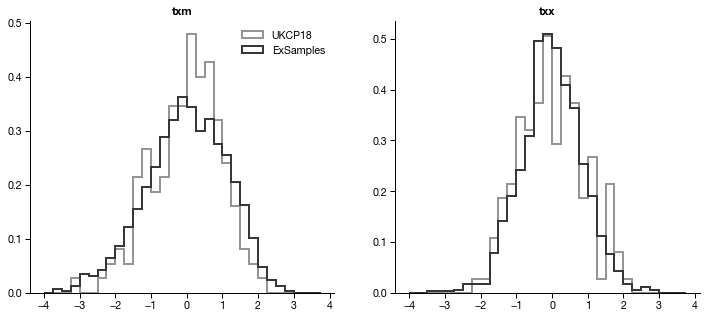

In [54]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

for i,var in enumerate(['txm','txx']):
    ax[i].hist((UKCP_df.loc[2007:2016,var] - UKCP_df.loc[2007:2016,var].mean()).values.flatten(),bins=np.arange(-4,4,0.25),histtype='step',density=True,label='UKCP18',color='xkcd:grey',lw=2)
    ax[i].hist((ExS_base[var]-ExS_base[var].groupby(level=0).transform('mean')).values.flatten(),bins=np.arange(-4,4,0.25),histtype='step',density=True,label='ExSamples',color='xkcd:dark grey',lw=2)
    
    ax[i].set_title(var,fontweight='bold')

ax[0].legend(frameon=False)
sn.despine()
''